# Advanced RAG: Automated Structured Metadata Enrichment

by Tuana Celik ([LI](https://www.linkedin.com/in/tuanacelik/), [Twitter](https://x.com/tuanacelik))

> This is part one of the **Advanced Use Cases** series:
>
> 1️⃣ Extract Metadata from Queries to Improve Retrieval [cookbook](/cookbook/extracting_metadata_filters_from_a_user_query) & [full article](/blog/extracting-metadata-filter)
>
> 2️⃣ Query Expansion [cookbook](/cookbook/query-expansion) & [full article](/blog/query-expansion)
>
> 3️⃣ Query Decomposition [cookbook](/cookbook/query_decomposition) & the [full article](/blog/query-decomposition)
>
> 4️⃣ **Automated Metadata Enrichment**

In this example, you'll see how you can make use of structured outputs which is an option for some LLMs, and a custom Haystack component, to automate the enrichment of metadata from documents.

You will see how you can define your own metadata fields as a Pydantic Model, as well as the data types each field should have. Finally, you will get a custom `MetadataEnricher` to extract the required fields and add them to the document meta information.

In this example, we will be enriching metadata with information relating the funding announements.

Once we populate the metadata of a document with our own fields, we are able to use Metadata Filtering during the retrieval step of RAG pipelines. We can even combine this with [Metadata Extraction from Queries to Improve Retrieval](https://haystack.deepset.ai/blog/extracting-metadata-filter) to be very precise about what documents we are providing as context to an LLM.

## 📺 Code Along

<iframe width="560" height="315" src="https://www.youtube.com/embed/vk0U1V-cBK0?si=-MHeM23RRfdlAlgm" title="YouTube video player" frameborder="0" allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture; web-share" referrerpolicy="strict-origin-when-cross-origin" allowfullscreen></iframe>

### Install requirements

In [ ]:
!pip install haystack-ai
!pip install trafilatura

In [70]:
from haystack import Document, component, Pipeline
from haystack.components.builders import PromptBuilder
from haystack.components.converters import HTMLToDocument
from haystack.components.fetchers import LinkContentFetcher
from haystack.components.generators import OpenAIGenerator
from haystack.components.generators.openai_utils import _convert_message_to_openai_format
from haystack.components.preprocessors import DocumentSplitter
from haystack.dataclasses import ChatMessage, StreamingChunk

from openai import Stream
from openai.types.chat import ChatCompletion, ChatCompletionChunk
from typing import List, Any, Dict, Optional, Callable, Union
from pydantic import BaseModel

## 🧪 Experimental Addition to the OpenAIGenerator for Structured Output Support

> 🚀 This is the same extension to the `OpenAIGenerator` that was used in the [Advanced RAG: Query Decomposition and Reasoning](https://haystack.deepset.ai/cookbook/query_decomposition) example

Let's extend the `OpenAIGeneraotor` to be able to make use of the [strctured output option by OpenAI](https://platform.openai.com/docs/guides/structured-outputs/introduction). Below, we extend the class to call `self.client.beta.chat.completions.parse` if the user has provides a `respose_format` in `generation_kwargs`. This will allow us to provifde a Pydantic Model to the gnerator and request our generator to respond with structured outputs that adhere to this Pydantic schema.

In [71]:
class OpenAIGenerator(OpenAIGenerator):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    @component.output_types(replies=List[str], meta=List[Dict[str, Any]], structured_reply=BaseModel)
    def run(self, prompt: str, streaming_callback: Optional[Callable[[StreamingChunk], None]] = None, generation_kwargs: Optional[Dict[str, Any]] = None,):
      generation_kwargs = {**self.generation_kwargs, **(generation_kwargs or {})}
      if "response_format" in generation_kwargs.keys():
        message = ChatMessage.from_user(prompt)
        if self.system_prompt:
            messages = [ChatMessage.from_system(self.system_prompt), message]
        else:
            messages = [message]

        streaming_callback = streaming_callback or self.streaming_callback
        openai_formatted_messages = [_convert_message_to_openai_format(message) for message in messages]
        completion: Union[Stream[ChatCompletionChunk], ChatCompletion] = self.client.beta.chat.completions.parse(
            model=self.model,
            messages=openai_formatted_messages,
            **generation_kwargs)
        completions = [self._build_structured_message(completion, choice) for choice in completion.choices]
        for response in completions:
            self._check_finish_reason(response)

        return {
            "replies": [message.content for message in completions],
            "meta": [message.meta for message in completions],
            "structured_reply": completions[0].content
        }
      else:
          return super().run(prompt, streaming_callback, generation_kwargs)

    def _build_structured_message(self, completion: Any, choice: Any) -> ChatMessage:
        chat_message = ChatMessage.from_assistant(choice.message.parsed or "")
        chat_message.meta.update(
            {
                "model": completion.model,
                "index": choice.index,
                "finish_reason": choice.finish_reason,
                "usage": dict(completion.usage),
            }
        )
        return chat_message

In [3]:
import os
from getpass import getpass

if "OPENAI_API_KEY" not in os.environ:
  os.environ["OPENAI_API_KEY"] = getpass("OpenAI API Key:")

OpenAI API Key:··········


## Custom `MetadataEnricher`

We create a custom Haystack component that is able ti accept `metadata_model` and `prompt`. If no prompt is provided, it usees the `DEFAULT_PROMPT`.

This component returns `documents` enriched with the requested metadata fileds.

In [72]:
DEFAULT_PROMPT = """
Given the contents of the documents, extract the requested metadata.
The requested metadata is {{ metadata_model }}
Document:
{{document}}
Metadata:
"""
@component
class MetadataEnricher:

    def __init__(self, metadata_model: BaseModel, prompt:str = DEFAULT_PROMPT):
        self.metadata_model = metadata_model
        self.metadata_prompt = prompt

        builder = PromptBuilder(self.metadata_prompt)
        llm = OpenAIGenerator(generation_kwargs={"response_format": metadata_model})
        self.pipeline = Pipeline()
        self.pipeline.add_component(name="builder", instance=builder)
        self.pipeline.add_component(name="llm", instance=llm)
        self.pipeline.connect("builder", "llm")

    @component.output_types(documents=List[Document])
    def run(self, documents: List[Document]):
        documents_with_meta = []
        for document in documents:
          result = self.pipeline.run({'builder': {'document': document.content, 'metadata_model': self.metadata_model}})
          metadata = result['llm']['structured_reply']
          document.meta.update(metadata.dict())
          documents_with_meta.append(document)
        return {"documents": documents_with_meta}

## Define Metadata Fields as a Pydantic Model

For automatic metadata enrichment, we want to be able to provide a structure describing what fields we want to extract, as well as what types they should be.

Below, I have defined a `Metadata` model, with 4 fields.

> 💡 **Note:** In some cases, it might make sense to make each field optional, or provide default values.

In [73]:
class Metadata(BaseModel):
    company: str
    year: int
    funding_value: int
    funding_currency: str

Next, we initialize a `MetadataEnricher` and provide `Metadata` as the `metadata_model` we want to abide by.

In [79]:
enricher = MetadataEnricher(metadata_model=Metadata)

## Build an Automated Metadata Enrichment Pipeline

Now that we have our `enricher`, we can use it in a pipeline. Below is an example of a pipeline that fetches the contents of some URLs (in this case, urls that contain information about funding announcements). The pipeline then adds the requested metadata fields to each `Document`'s `meta` field 👇

In [80]:
pipeline = Pipeline()
pipeline.add_component("fetcher", LinkContentFetcher())
pipeline.add_component("converter", HTMLToDocument())
pipeline.add_component("enricher", enricher)


pipeline.connect("fetcher", "converter")
pipeline.connect("converter.documents", "enricher.documents")

pipeline.run({"fetcher": {"urls": ['https://techcrunch.com/2023/08/09/deepset-secures-30m-to-expand-its-llm-focused-mlops-offerings/',
                                   'https://www.prnewswire.com/news-releases/arize-ai-raises-38-million-series-b-to-scale-machine-learning-observability-platform-301620603.html']}})

{'enricher': {'documents': [Document(id=5844517120556b13f92430ea8af9837714ede1b351580c43c2ddce9b646cb6cb, content: 'Deepset, a platform for building enterprise apps powered by large language models akin to ChatGPT, t...', meta: {'content_type': 'text/html', 'url': 'https://techcrunch.com/2023/08/09/deepset-secures-30m-to-expand-its-llm-focused-mlops-offerings/', 'company': 'Deepset', 'year': 2023, 'funding_value': 30000000, 'funding_currency': 'USD'}),
   Document(id=8cdcb63a4e006b1cac902ebc2e012cd95156d188777e0d0c8bd407a92f4491c7, content: 'Arize AI Raises $38 Million Series B To Scale Machine Learning Observability Platform
   As companies t...', meta: {'content_type': 'text/html', 'url': 'https://www.prnewswire.com/news-releases/arize-ai-raises-38-million-series-b-to-scale-machine-learning-observability-platform-301620603.html', 'company': 'Arize AI', 'year': 2022, 'funding_value': 38000000, 'funding_currency': 'USD'})]}}

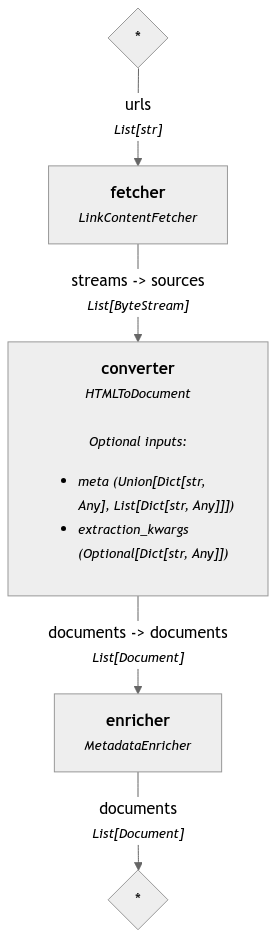

In [81]:
pipeline.show()

## Extra: Metadata Inheritance

This is just an extra step to show how metadata that belongs to a document is inherited by the document chunks if you use a component such as the `DocumentSplitter`.

In [82]:
pipeline.add_component("splitter", DocumentSplitter())

pipeline.connect("enricher", "splitter")

🚅 Components
  - fetcher: LinkContentFetcher
  - converter: HTMLToDocument
  - enricher: MetadataEnricher
  - splitter: DocumentSplitter
🛤️ Connections
  - fetcher.streams -> converter.sources (List[ByteStream])
  - converter.documents -> enricher.documents (List[Document])
  - enricher.documents -> splitter.documents (List[Document])

In [83]:
pipeline.run({"fetcher": {"urls": ['https://techcrunch.com/2023/08/09/deepset-secures-30m-to-expand-its-llm-focused-mlops-offerings/',
                                   'https://www.prnewswire.com/news-releases/arize-ai-raises-38-million-series-b-to-scale-machine-learning-observability-platform-301620603.html']}})

{'splitter': {'documents': [Document(id=9611aa2bdb658163d8f6964220052065936fcd036dd24743d1b34ce79d25bc5a, content: 'Deepset, a platform for building enterprise apps powered by large language models akin to ChatGPT, t...', meta: {'content_type': 'text/html', 'url': 'https://techcrunch.com/2023/08/09/deepset-secures-30m-to-expand-its-llm-focused-mlops-offerings/', 'company': 'Deepset', 'year': 2023, 'funding_value': 30000000, 'funding_currency': 'USD', 'source_id': '5844517120556b13f92430ea8af9837714ede1b351580c43c2ddce9b646cb6cb', 'page_number': 1, 'split_id': 0, 'split_idx_start': 0}),
   Document(id=6bffbcf9f1cd1a3940628d1450c9ba9a8c9a092136896d295b35af3175caffbf, content: 'unfortunate state of affairs is likely contributing to challenges around AI development within the e...', meta: {'content_type': 'text/html', 'url': 'https://techcrunch.com/2023/08/09/deepset-secures-30m-to-expand-its-llm-focused-mlops-offerings/', 'company': 'Deepset', 'year': 2023, 'funding_value': 30000000, 'fun